In [1]:
%reload_ext autoreload

In [2]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0
#!pip install eli5
#!pip install ggplot
#!pip install pdp

In [4]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
from pandas import Timestamp
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
sys.path.append('../lib')
import utils
import preprocessing

In [6]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [7]:
print(len(df_raw), df_raw.shape)
df_processed = preprocessing.prepare_data(df_raw.loc[df_raw.licence_status != "STAGING"])
print(len(df_processed), df_processed.shape)

5889 (5889, 38)
Feature has NaN values: last_login_categories
5547 (5547, 138)


In [8]:
utils.display_all(df_processed[df_processed.last_login_categories.isna()])

,days_active,team,vertical,salesperson,golive_days,cases_total,cases_open,cases_closed,cases_age_hours_total,cases_age_hours_average,annual_revenue,interactions_total,interactions_completed,interactions_no_response,interactions_no_onboarding,interactions_completed_training,churn_concern_cases_total,churn_concern_cases_open,churn_concern_cases_avg_hours,churned,cases_totalwas_nan,cases_openwas_nan,cases_closedwas_nan,cases_age_hours_totalwas_nan,cases_age_hours_averagewas_nan,last_login_dayswas_nan,annual_revenue_was_missing,last_login_categories,customer_account_status_PoorStanding,plan_BASIC,plan_BRONZE,plan_BUSINESS,plan_BUSINESS +,plan_BUSINESS ONE,plan_CUSTOM,plan_CUSTOM XL,plan_ENTERPRISE,plan_GOLD,plan_GROW,plan_L&S - PREMIUM,plan_L&S - STANDARD,plan_L&S - ULTIMATE,plan_LIST N SEND SILVER,plan_LISTNSEND,plan_NETO XL,plan_PLAN-360-17Q2,plan_PLAN-360-19Q1,plan_PLAN-360-TRANSITION,plan_PLAN-360-US,plan_PLAN-L,plan_PLAN-L-17Q2,plan_PLAN-L-19Q1,plan_PLAN-M,plan_PLAN-M-17Q2,plan_PLAN-M-19Q1,plan_PLAN-M-US,plan_PLAN-S,plan_PLAN-S-17Q2,plan_PLAN-S-19Q1,plan_PLAN-S-US,plan_PLAN-XL-19Q1,plan_PLAN-XS,plan_PLAN-XS-17Q2,plan_PREMIUM,plan_STANDARD,plan_START,plan_START - LEGACY,plan_TRIAL,plan_ULTIMATE,plan_ULTIMATE PLUS,nps_no_data,nps_detractor,nps_passive,nps_promoter,licence_registration_Year,licence_registration_Month,licence_registration_Week,licence_registration_Day,licence_registration_Dayofweek,licence_registration_Dayofyear,licence_registration_Is_month_end,licence_registration_Is_month_start,licence_registration_Is_quarter_end,licence_registration_Is_quarter_start,licence_registration_Is_year_end,licence_registration_Is_year_start,licence_registration_Elapsed,golive_Year,golive_Month,golive_Week,golive_Day,golive_Dayofweek,golive_Dayofyear,golive_Is_month_end,golive_Is_month_start,golive_Is_quarter_end,golive_Is_quarter_start,golive_Is_year_end,golive_Is_year_start,golive_Elapsed,days_active_was_nan,golive_days_was_nan,cases_total_was_nan,cases_open_was_nan,cases_closed_was_nan,cases_age_hours_total_was_nan,cases_age_hours_average_was_nan,annual_revenue_was_nan,interactions_total_was_nan,interactions_completed_was_nan,interactions_no_response_was_nan,interactions_no_onboarding_was_nan,interactions_completed_training_was_nan,churn_concern_cases_total_was_nan,churn_concern_cases_open_was_nan,churn_concern_cases_avg_hours_was_nan,churned_was_nan,cases_totalwas_nan_was_nan,cases_openwas_nan_was_nan,cases_closedwas_nan_was_nan,cases_age_hours_totalwas_nan_was_nan,cases_age_hours_averagewas_nan_was_nan,last_login_dayswas_nan_was_nan,annual_revenue_was_missing_was_nan,licence_registration_Year_was_nan,licence_registration_Month_was_nan,licence_registration_Week_was_nan,licence_registration_Day_was_nan,licence_registration_Dayofweek_was_nan,licence_registration_Dayofyear_was_nan,licence_registration_Elapsed_was_nan,golive_Year_was_nan,golive_Month_was_nan,golive_Week_was_nan,golive_Day_was_nan,golive_Dayofweek_was_nan,golive_Dayofyear_was_nan,golive_Elapsed_was_nan
0,1851,not specified,not specified,dominic,-1,5,0,0,1159,249,6.172918e+04,2.0,2.0,0.0,0.0,0.0,1.0,0.0,404.0,1,1,1,1,1,1,1,1,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2010,7,26,3,5,184,False,False,False,False,False,False,1278115200,1970,1,1,1,3,1,False,True,False,True,False,True,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2269,Neto XL,Sports & Recreation,not specified,-1,22,1,1,4795,217,3.684476e+07,1.0,1.0,0.0,0.0,0.0,1.0,0.0,404.0,0,1,1,1,1,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2013,7,29,16,1,197,False,False,False,False,False,False,1373932800,1970,1,1,1,3,1,False,True,False,True,False,True,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2268,not specified,Health & Beauty,cat,-1,4,0,0,170,42,5.551790e+03,3.0,2.0,1.0,0.0,0.0,1.0,0.0,404.0,0,1,1,1,1,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [9]:
#df_filtered = df_processed.loc[df_processed.licence_registration_Year > 2015]
df_filtered = df_processed

In [10]:
df_trn, y_trn, nas = proc_df(df_filtered, 'churned')
print(len(df_trn), df_trn.shape)

5547 (5547, 137)


In [11]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [12]:
X_train.shape, y_train.shape

((5047, 137), (5047,))

In [13]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [14]:
X_train_res.shape, y_train_res.shape

((5916, 137), (5916,))

In [15]:
# Show any features with NaN values
preprocessing.features_with_nan(df_filtered)

Feature has NaN values: last_login_categories


In [16]:
X_train.shape, y_train.shape

((5047, 137), (5047,))

In [17]:
m = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=3, 
    max_features='sqrt',
    n_jobs=-1,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train_res, y_train_res)
#m.fit(X_train, y_train)

y_pred = m.predict(X_valid)
print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "churn_model.pkl"
joblib.dump(m, joblib_file)

0.8979591836734694 0.5827814569536424 0.7068273092369478 0.854 0.6154008260979515 0.146
None
tp, fn, fp, tn
[[339  10]
 [ 63  88]]


['churn_model.pkl']

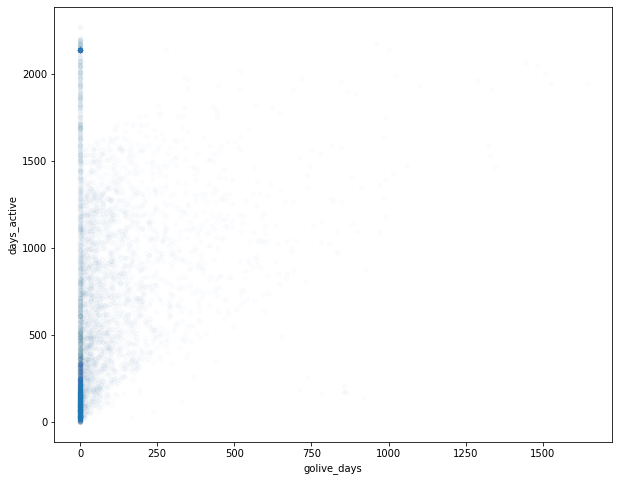

In [18]:
df_filtered.plot('golive_days', 'days_active', 'scatter', alpha=0.01, figsize=(10,8));

In [23]:
X_train.columns

Index(['days_active', 'team', 'vertical', 'salesperson', 'golive_days',
       'cases_total', 'cases_open', 'cases_closed', 'cases_age_hours_total',
       'cases_age_hours_average',
       ...
       'licence_registration_Dayofweek_was_nan',
       'licence_registration_Dayofyear_was_nan',
       'licence_registration_Elapsed_was_nan', 'golive_Year_was_nan',
       'golive_Month_was_nan', 'golive_Week_was_nan', 'golive_Day_was_nan',
       'golive_Dayofweek_was_nan', 'golive_Dayofyear_was_nan',
       'golive_Elapsed_was_nan'],
      dtype='object', length=137)

Index(['days_active', 'team', 'vertical', 'salesperson', 'golive_days',
       'cases_total', 'cases_open', 'cases_closed', 'cases_age_hours_total',
       'cases_age_hours_average',
       ...
       'licence_registration_Dayofweek_was_nan',
       'licence_registration_Dayofyear_was_nan',
       'licence_registration_Elapsed_was_nan', 'golive_Year_was_nan',
       'golive_Month_was_nan', 'golive_Week_was_nan', 'golive_Day_was_nan',
       'golive_Dayofweek_was_nan', 'golive_Dayofyear_was_nan',
       'golive_Elapsed_was_nan'],
      dtype='object', length=137)
days_active


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2a14a6a0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2a1440b8>})

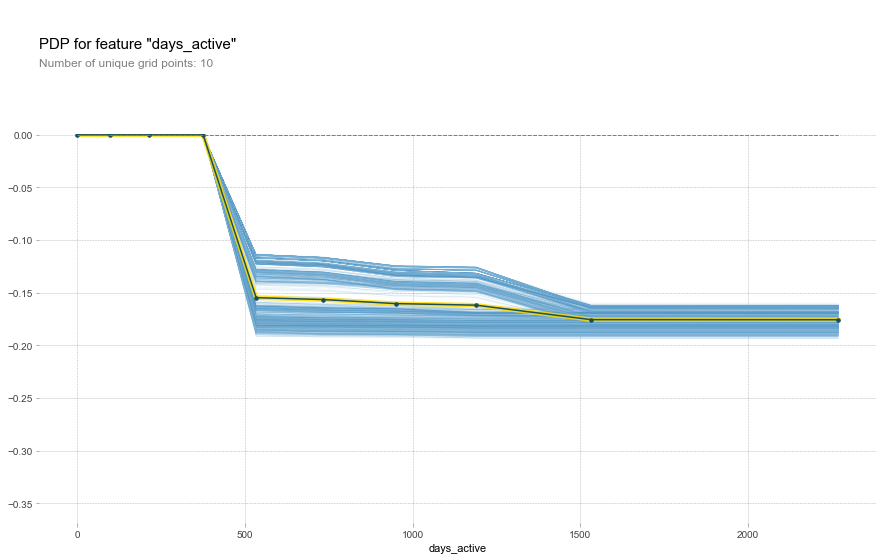

In [27]:
from pdpbox import pdp

x = get_sample(X_train, 2000)

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns,feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

plot_pdp('days_active')

days_active


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2bce8f98>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2a641588>})

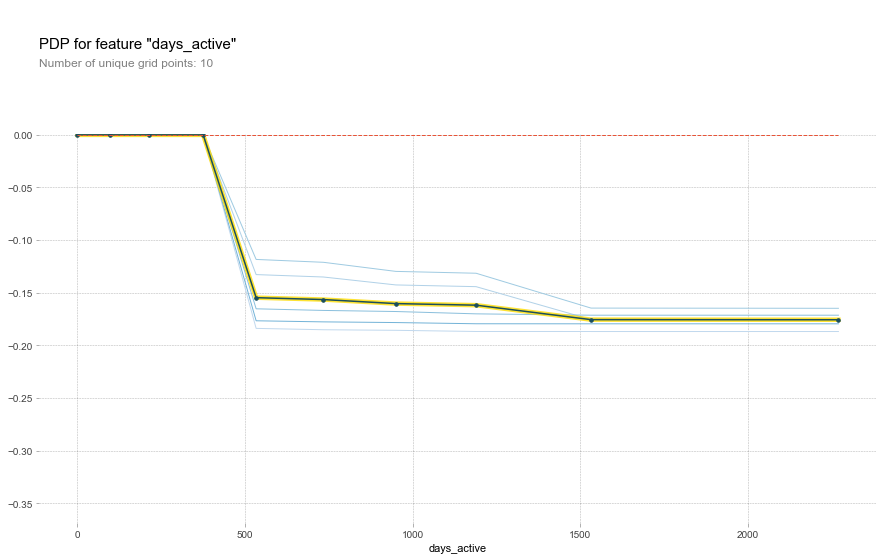

In [28]:
plot_pdp('days_active', clusters=5)

In [ ]:
fi = rf_feat_importance(m, X_valid); fi[:10]

In [ ]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [20]:
to_keep = fi[fi.imp<0.17].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

NameError: name 'fi' is not defined

In [21]:
m = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=3, 
    max_features='sqrt',
    n_jobs=-1, 
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 4, 1: 1},
                       criterion='entropy', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

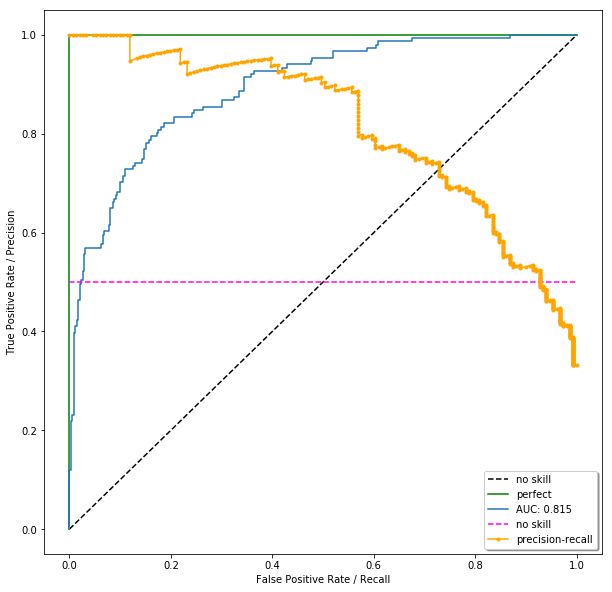

auc=0.815 ap=0.816


In [22]:
utils.plot_roc_pr(m, X_valid, y_valid)

In [23]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in l

ValueError: Distance matrix 'X' must be symmetric.

In [24]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
0.9893238434163701 0.563894523326572 0.7183462532299741 0.7408361402813552 0.509690362935175 0.25916385971864475
days_active None
0.9942013705851345 0.6375929682217715 0.776930998970134 0.7854170794531404 0.5884275879590073 0.2145829205468595
annual_revenue None
0.9939455095862765 0.6659905341446923 0.7975708502024291 0.8018624925698434 0.6178445615502715 0.19813750743015654
cases_total None
0.9936642027455121 0.6362407031778229 0.775762572135202 0.7844263919159897 0.5866085880296376 0.2155736080840103
cases_closed None


KeyboardInterrupt: 